In [1]:
from process_eeg import *
from PyEMD import EMD
import pandas as pd

In [38]:
def get_eeg_bis_from_mat(matfile):
    f = h5py.File(matfile, mode='r')
    data={}
    for a, b in f.items():
        data[a]=np.array(b)
    eeg = data['EEG'].ravel()
    bis = data['bis'].ravel()
    return eeg, bis
    
def get_time_arr(eeg, bis, eeg_ratio=1/125, bis_ratio=5):
    eegt = np.array([(eeg_ratio)*i for i in range(len(eeg))])
    bist = np.array([(bis_ratio)*i for i in range(len(bis))])
    return eegt, bist

def plot_bis_with_range(mat_file, mat_idx, pointer=[], title=None):    

    eeg, bis = get_eeg_bis_from_mat(mat_file%mat_idx)
    eegt, bist = get_time_arr(eeg, bis)
    print(eeg.shape, eegt.shape, bis.shape, bist.shape)
    
    fig = plt.figure(figsize=(12,5))
    if title: plt.title(title)
    plt.plot(bist, bis,  marker='.')
    plt.xlabel("Time")
    
    for i in [40, 60, 65, 80, 85]:
        plt.plot((0,bist[-1]),(i,i), color='red', alpha=0.5)
        plt.text(-100, i, str(i))

    for p in pointer:
        plt.plot((bist[p],bist[p]),(0,100), color='green', alpha=0.5)
        plt.text(bist[p], bis[p]+3, "%i"%(bis[p]))
        plt.text(bist[p], 0, "%i"%(bist[p]))

    plt.show()

def split_by_time(x, t, mn_t, mx_t):
    mask = (t>=mn_t)&(t <= mx_t)
    x_cutted, t_cutted = x[mask], t[mask]
    return x_cutted, t_cutted

def process_high_data(eeg, eegt, i, c, window_size=125*8, step_size=25):
    
    n_step = int(np.trunc(len(eeg)/step_size))
    x_out, t_out, y_out = [], [], []
    for step in range(n_step):
        start = step*step_size
        end = start+window_size
        x = eeg[start:end]
        t = eegt[start:end]
        cnt = len(x[np.abs(x)<0.04])
        
        if (len(x)==(window_size)) and (cnt<200):
            x_out.append(x)
            t_out.append(t)
            y_out.append([i, c])
            
    return np.array(x_out), np.array(t_out), np.array(y_out)

def process_low_data(eeg, eegt, bis, bist, i, window_size=125*8):

    x_out, t_out, y_out = [], [], []
    for b, bt in zip(bis, bist):
        start = bt-8
        end = bt
        mask = (eegt>=start) & (eegt<end)
        x = eeg[mask]
        t = eegt[mask]
        cnt = len(x[np.abs(x)<0.04])
        if (len(x)==(window_size)) and (cnt<200):
            x_out.append(x)
            t_out.append(t)
            y_out.append([i, b])
    
    return np.array(x_out), np.array(t_out), np.array(y_out)

(483648,) (483648,) (775,) (775,)


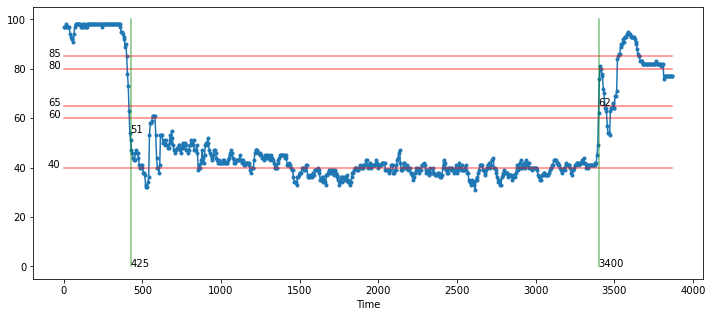

In [35]:
plot_bis_with_range(mat_file, 24, pointer=[85, 680], title=None)

In [3]:
cond_xslsx_h = '/Users/nibey/Downloads/RangeCondition_H.xlsx'
cond_xslsx_l = '/Users/nibey/Downloads/RangeCondition_L.xlsx'
mat_file = 'data/org/case%i.mat'

In [13]:
cond_h = pd.read_excel(cond_xslsx_h)

xh_data, th_data, yh_data = [], [], []
for i, c, _, _, ts, te in cond_h.values:
    eeg, bis = get_eeg_bis_from_mat(mat_file%i)
    eegt, bist = get_time_arr(eeg, bis)
    
    # split time range
    eeg, eegt = split_by_time(eeg, eegt, ts, te)
    bis, bist = split_by_time(bis, bist, ts, te)
    xh, th, yh = process_high_data(eeg, eegt, i, c)        

    xh_data.extend(xh)
    th_data.extend(th)
    yh_data.extend(yh)

xh_data = np.array(xh_data)
th_data = np.array(th_data)
yh_data = np.array(yh_data)

xh_data.shape, th_data.shape, yh_data.shape

((86961, 1000), (86961, 1000), (86961, 2))

In [102]:
cond_l = pd.read_excel(cond_xslsx_l)

xl_data, tl_data, yl_data = [], [], []
for i, _, _, ts, te in cond_l.values:
    eeg, bis = get_eeg_bis_from_mat(mat_file%i)
    eegt, bist = get_time_arr(eeg, bis)
    
    # split time range
    eeg, eegt = split_by_time(eeg, eegt, ts, te)
    bis, bist = split_by_time(bis, bist, ts, te)
    xl, tl, yl = process_low_data(eeg, eegt, bis, bist, i)
    xl_data.extend(xl)
    tl_data.extend(tl)
    yl_data.extend(yl)

xl_data = np.array(xl_data)
tl_data = np.array(tl_data)
yl_data = np.array(yl_data)

xl_data.shape, tl_data.shape, yl_data.shape

((27398, 1000), (27398, 1000), (27398, 2))

# Simple Classification

* low y -> down 60

In [103]:
xl_data, yl_data = xl_data[yl_data[:,1]<60], yl_data[yl_data[:,1]<60]

mask_train = yl_data[:,0]!=24
mask_test  = yl_data[:,0]==24

xl_train, xl_test = xl_data[mask_train], xl_data[mask_test]
yl_train, yl_test = yl_data[mask_train][:,1], yl_data[mask_test][:,1]

xl_train.shape, yl_train.shape, xl_test.shape, yl_test.shape

((25999, 1000), (25999,), (589, 1000), (589,))

In [105]:
mask_train = yh_data[:,0]!=24
mask_test  = yh_data[:,0]==24

xh_train, xh_test = xh_data[mask_train], xh_data[mask_test]
yh_train, yh_test = yh_data[mask_train][:,1], yh_data[mask_test][:,1]

xh_train.shape, yh_train.shape, xh_test.shape, yh_test.shape

((83433, 1000), (83433,), (3528, 1000), (3528,))

# Test for one sub

In [116]:
x_test_real = np.concatenate((xh_test, xl_test))
y_test_real = np.concatenate((yh_test, np.array([3 for _ in range(len(xl_test))])))
x_test_real.shape, y_test_real.shape

((4117, 1000), (4117,))

# Dataset

In [117]:
x1_train, x2_train = xh_train[yh_train==1], xh_train[yh_train==2]

x1_train = np.array(random.choices(x1, k=len(xl_train)))
x2_train = np.array(random.choices(x2, k=len(xl_train)))
x1_train.shape, x2_train.shape

((25999, 1000), (25999, 1000))

In [118]:
x_data = np.concatenate((x1_train,x2_train,xl_train))
y_data = np.array([1 for _ in range(len(x1_train))]+
                   [2 for _ in range(len(x2_train))]+
                   [3 for _ in range(len(xl_train))])

x_data.shape, y_data.shape

((77997, 1000), (77997,))

In [94]:
from sklearn.model_selection import train_test_split

def get_train_valid_test(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y,
                                       test_size=0.1,shuffle=True, random_state=1)
    
    x_train, x_valid, y_train, y_valid=train_test_split(x_train, y_train,
                                       test_size=0.2, shuffle=True, random_state=1)
    return x_train, y_train, x_valid, y_valid, x_test, y_test
                            

In [119]:
x_train, y_train, x_valid, y_valid, x_test, y_test = get_train_valid_test(x_data, y_data)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((56157, 1000), (56157,), (14040, 1000), (14040,), (7800, 1000), (7800,))